In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

from fairlearn.metrics import (
    MetricFrame, selection_rate, demographic_parity_difference,
    demographic_parity_ratio, equalized_odds_difference,
    true_positive_rate, false_positive_rate
)
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds

In [15]:
np.random.seed(42)
RANDOM_STATE = 42

def metrics_global(y_true, y_pred, y_prob=None):
    out = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
    }
    if y_prob is not None:
        out["roc_auc"] = roc_auc_score(y_true, y_prob)
    return {k: round(v, 4) for k, v in out.items()}

def group_metricframe(y_true, y_pred, sensitive):
    mf = MetricFrame(
        metrics={
            "accuracy": accuracy_score,
            "precision": precision_score,
            "recall": recall_score,
            "f1": f1_score,
            "selection_rate": selection_rate,  
            "tpr": true_positive_rate,
            "fpr": false_positive_rate,
        },
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive
    )
    dp_diff = demographic_parity_difference(
        y_true, y_pred, sensitive_features=sensitive
    )
    dp_ratio = demographic_parity_ratio(
        y_true, y_pred, sensitive_features=sensitive
    )
    eo_diff = equalized_odds_difference(
        y_true, y_pred, sensitive_features=sensitive
    )
    return mf, {
        "dp_diff": round(dp_diff, 4),
        "dp_ratio": round(dp_ratio, 4),
        "eo_diff": round(eo_diff, 4),
    }

def plot_selection_rate(mf, title):
    sr = mf.by_group['selection_rate'].sort_values(ascending=False)
    sr.plot(kind='bar')
    plt.title(title)
    plt.ylabel('Selection Rate (ŷ=1)')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [16]:
def load_adult_single(csv_path):
    cols = [
        "age","workclass","fnlwgt","education","education-num","marital-status",
        "occupation","relationship","race","sex","capital-gain","capital-loss",
        "hours-per-week","native-country","income"
    ]
    try:
        df = pd.read_csv(csv_path, na_values="?", skipinitialspace=True)
        if 'income' not in df.columns or len(df.columns) != 15:
            df = pd.read_csv(csv_path, header=None, names=cols, na_values="?", skipinitialspace=True)
    except Exception as e:
        df = pd.read_csv(csv_path, header=None, names=cols, na_values="?", skipinitialspace=True)

    for c in df.select_dtypes(include='object').columns:
        df[c] = df[c].astype(str).str.strip()

    df['income'] = df['income'].astype(str).str.replace('.', '', regex=False)

    df.replace('?', np.nan, inplace=True)

    return df

CSV_PATH = "adult.csv" 
df = load_adult_single(CSV_PATH)

df_clean = df.dropna(subset=["income", "sex", "race"]).copy()

df_clean

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,nan,77053,HS-grad,9,Widowed,nan,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,nan,186061,Some-college,10,Widowed,nan,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [17]:
import re

def _norm(s):
    return re.sub(r'[^a-z0-9]+', '_', str(s).strip().lower())

canonical = {
    'age':'age',
    'workclass':'workclass',
    'fnlwgt':'fnlwgt',
    'education':'education',
    'education_num':'education-num',
    'education-num':'education-num',
    'marital_status':'marital-status',
    'marital-status':'marital-status',
    'occupation':'occupation',
    'relationship':'relationship',
    'race':'race',
    'sex':'sex',
    'capital_gain':'capital-gain',
    'capital-gain':'capital-gain',
    'capital_loss':'capital-loss',
    'capital-loss':'capital-loss',
    'hours_per_week':'hours-per-week',
    'hours-per-week':'hours-per-week',
    'native_country':'native-country',
    'native-country':'native-country',
    'income':'income',
    'class':'income',
    'salary':'income',
    'target':'income',
}

rename_map = {}
for c in df_clean.columns:
    key = _norm(c)
    if key in canonical:
        rename_map[c] = canonical[key]

df_clean = df_clean.rename(columns=rename_map)

print("Columnas actuales:")
print(sorted(df_clean.columns))

required = ['age','workclass','fnlwgt','education','education-num','marital-status',
            'occupation','relationship','race','sex','capital-gain','capital-loss',
            'hours-per-week','native-country','income']
missing = [c for c in required if c not in df_clean.columns]
print("Faltan (si hay):", missing)

Columnas actuales:
['age', 'capital-gain', 'capital-loss', 'education', 'education-num', 'fnlwgt', 'hours-per-week', 'income', 'marital-status', 'native-country', 'occupation', 'race', 'relationship', 'sex', 'workclass']
Faltan (si hay): []


In [18]:
SENSITIVE_SEX  = "sex"
SENSITIVE_RACE = "race"

assert SENSITIVE_SEX in df_clean.columns, "No se encontró la columna 'sex'. Revisa tu CSV o el mapeo."
assert SENSITIVE_RACE in df_clean.columns, "No se encontró la columna 'race'. Revisa tu CSV o el mapeo."
assert 'income' in df_clean.columns, "No se encontró la columna objetivo ('income')."

y = (df_clean["income"] == ">50K").astype(int)

numeric_candidates = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
categorical_candidates = ['workclass','education','marital-status','occupation','relationship','native-country']

numeric_features = [c for c in numeric_candidates if c in df_clean.columns]
categorical_features = [c for c in categorical_candidates if c in df_clean.columns]

print("Numéricas usadas:", numeric_features)
print("Categóricas usadas:", categorical_features)





Numéricas usadas: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categóricas usadas: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country']


In [19]:
print("Nulos por columna:")
display(df_clean.isna().mean().sort_values(ascending=False).round(3))

print("Distribución income:")
display(y.value_counts(normalize=True).rename({0:"<=50K",1:">50K"}).round(3))

print("Distribución sex:")
display(df_clean['sex'].value_counts(normalize=True).round(3))

print("Distribución race:")
display(df_clean['race'].value_counts(normalize=True).round(3))


Nulos por columna:


age               0.0
workclass         0.0
fnlwgt            0.0
education         0.0
education-num     0.0
marital-status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital-gain      0.0
capital-loss      0.0
hours-per-week    0.0
native-country    0.0
income            0.0
dtype: float64

Distribución income:


income
<=50K    0.759
>50K     0.241
Name: proportion, dtype: float64

Distribución sex:


sex
Male      0.669
Female    0.331
Name: proportion, dtype: float64

Distribución race:


race
White                 0.854
Black                 0.096
Asian-Pac-Islander    0.032
Amer-Indian-Eskimo    0.010
Other                 0.008
Name: proportion, dtype: float64

In [20]:
X = df_clean[numeric_features + categorical_features].copy()
A_sex  = df_clean[SENSITIVE_SEX].copy()
A_race = df_clean[SENSITIVE_RACE].copy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, Asex_train, Asex_test, Arace_train, Arace_test = train_test_split(
    X, y, A_sex, A_race, test_size=0.25, random_state=42, stratify=y
)

len(X_train), len(X_test)


(24420, 8141)

In [21]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

base_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

base_clf.fit(X_train, y_train)

y_pred_base = base_clf.predict(X_test)
y_prob_base = base_clf.predict_proba(X_test)[:, 1]

print("Métricas globales (baseline):", metrics_global(y_test, y_pred_base, y_prob_base))

Métricas globales (baseline): {'accuracy': 0.8543, 'precision': 0.7422, 'recall': 0.6051, 'f1': 0.6667, 'roc_auc': 0.9}


,accuracy,precision,recall,f1,selection_rate,tpr,fpr
sex,,,,,,,
Female,0.929,0.733,0.551,0.629,0.082,0.551,0.025
Male,0.818,0.744,0.615,0.673,0.252,0.615,0.093


Disparidades sexo: {'dp_diff': np.float64(0.1699), 'dp_ratio': np.float64(0.3265), 'eo_diff': 0.0684}


,accuracy,precision,recall,f1,selection_rate,tpr,fpr
race,,,,,,,
Amer-Indian-Eskimo,0.873,0.444,0.444,0.444,0.114,0.444,0.071
Asian-Pac-Islander,0.825,0.698,0.561,0.622,0.206,0.561,0.084
Black,0.914,0.681,0.557,0.612,0.099,0.557,0.036
Other,0.937,0.429,1.000,0.600,0.111,1.000,0.067
White,0.848,0.750,0.609,0.672,0.208,0.609,0.070


Disparidades raza: {'dp_diff': np.float64(0.1083), 'dp_ratio': np.float64(0.4783), 'eo_diff': 0.5556}


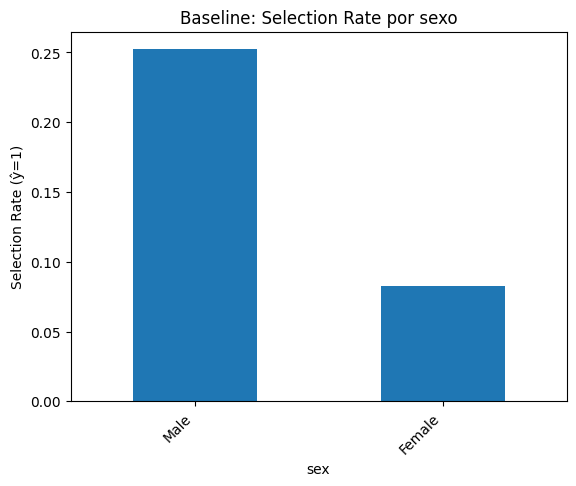

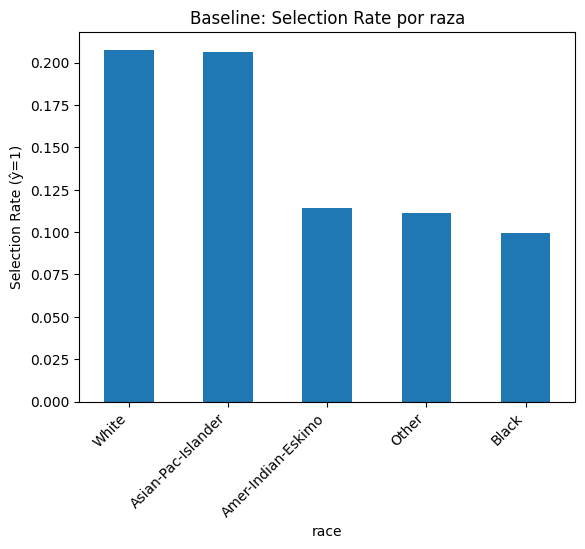

In [22]:
mf_sex_base,  disp_sex_base  = group_metricframe(y_test, y_pred_base, Asex_test)
mf_race_base, disp_race_base = group_metricframe(y_test, y_pred_base, Arace_test)

display(mf_sex_base.by_group.round(3));  print("Disparidades sexo:", disp_sex_base)
display(mf_race_base.by_group.round(3)); print("Disparidades raza:", disp_race_base)

plot_selection_rate(mf_sex_base,  "Baseline: Selection Rate por sexo")
plot_selection_rate(mf_race_base, "Baseline: Selection Rate por raza")

In [23]:
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from sklearn.linear_model import LogisticRegression

class PipeSW:
    def __init__(self, preprocess, estimator):
        self.preprocess = preprocess
        self.estimator = estimator
        self._fitted = False

    def fit(self, X, y, sample_weight=None):
        Xtr = self.preprocess.fit_transform(X, y)
        if sample_weight is not None:
            self.estimator.fit(Xtr, y, sample_weight=sample_weight)
        else:
            self.estimator.fit(Xtr, y)
        self._fitted = True
        return self

    def predict(self, X):
        Xte = self.preprocess.transform(X)
        return self.estimator.predict(Xte)

    def predict_proba(self, X):
        Xte = self.preprocess.transform(X)
        return self.estimator.predict_proba(Xte)

eq_odds = EqualizedOdds()
eg_estimator = PipeSW(preprocess, LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))

mitigator = ExponentiatedGradient(
    estimator=eg_estimator,
    constraints=eq_odds
)

Asex_train = pd.Series(Asex_train).reset_index(drop=True)
Asex_test  = pd.Series(Asex_test).reset_index(drop=True)
y_train    = pd.Series(y_train).reset_index(drop=True)
y_test     = pd.Series(y_test).reset_index(drop=True)

mitigator.fit(X_train, y_train, sensitive_features=Asex_train)
y_pred_eq = mitigator.predict(X_test)  

print("Métricas globales (Equalized Odds):", metrics_global(y_test, y_pred_eq))
mf_sex_eq, disp_sex_eq = group_metricframe(y_test, y_pred_eq, Asex_test)
display(mf_sex_eq.by_group.round(3)); print("Disparidades sexo (EQ):", disp_sex_eq)


Métricas globales (Equalized Odds): {'accuracy': 0.8438, 'precision': 0.7396, 'recall': 0.5418, 'f1': 0.6254}


,accuracy,precision,recall,f1,selection_rate,tpr,fpr
sex,,,,,,,
Female,0.908,0.584,0.568,0.576,0.107,0.568,0.050
Male,0.812,0.778,0.537,0.636,0.211,0.537,0.067


Disparidades sexo (EQ): {'dp_diff': np.float64(0.1041), 'dp_ratio': np.float64(0.5059), 'eo_diff': 0.0308}


In [24]:
def compare_mf(mf_before, mf_after):
    b = mf_before.by_group.add_suffix("_before")
    a = mf_after.by_group.add_suffix("_after")
    comp = b.join(a, how="outer")
    return comp.round(3).sort_index()

comp_sex = compare_mf(mf_sex_base, mf_sex_eq)
display(comp_sex)

,accuracy_before,precision_before,recall_before,f1_before,selection_rate_before,tpr_before,fpr_before,accuracy_after,precision_after,recall_after,f1_after,selection_rate_after,tpr_after,fpr_after
sex,,,,,,,,,,,,,,
Female,0.929,0.733,0.551,0.629,0.082,0.551,0.025,0.908,0.584,0.568,0.576,0.107,0.568,0.050
Male,0.818,0.744,0.615,0.673,0.252,0.615,0.093,0.812,0.778,0.537,0.636,0.211,0.537,0.067


In [25]:
comp_race = compare_mf(mf_race_base, mf_race_eq)
display(comp_race)


,accuracy_before,precision_before,recall_before,f1_before,selection_rate_before,tpr_before,fpr_before,accuracy_after,precision_after,recall_after,f1_after,selection_rate_after,tpr_after,fpr_after
race,,,,,,,,,,,,,,
Amer-Indian-Eskimo,0.873,0.444,0.444,0.444,0.114,0.444,0.071,0.861,0.333,0.222,0.267,0.076,0.222,0.057
Asian-Pac-Islander,0.825,0.698,0.561,0.622,0.206,0.561,0.084,0.829,0.729,0.530,0.614,0.187,0.530,0.068
Black,0.914,0.681,0.557,0.612,0.099,0.557,0.036,0.903,0.615,0.545,0.578,0.108,0.545,0.047
Other,0.937,0.429,1.000,0.600,0.111,1.000,0.067,0.889,0.167,0.333,0.222,0.095,0.333,0.083
White,0.848,0.750,0.609,0.672,0.208,0.609,0.070,0.838,0.752,0.544,0.631,0.185,0.544,0.062


In [26]:
def thresholds_for_demographic_parity(y_prob, sensitive, target_rate=None, grid=None):
    if grid is None:
        grid = np.linspace(0.01, 0.99, 99)
    dfp = pd.DataFrame({"p": y_prob, "g": sensitive})
    if target_rate is None:
        target_rate = (y_prob >= 0.5).mean()
    th = {}
    for g in dfp["g"].unique():
        p_g = dfp.loc[dfp["g"] == g, "p"].values
        best_t, best_diff = 0.5, 1.0
        for t in grid:
            rate = (p_g >= t).mean()
            d = abs(rate - target_rate)
            if d < best_diff:
                best_diff, best_t = d, t
        th[g] = best_t
    return th

def predict_with_group_thresholds(y_prob, sensitive, thresholds):
    return np.array([1 if p >= thresholds[g] else 0 for p, g in zip(y_prob, sensitive)])

thr_sex = thresholds_for_demographic_parity(y_prob_base, Asex_test)
y_pred_thr = predict_with_group_thresholds(y_prob_base, Asex_test, thr_sex)

print("Umbrales por sexo:", {k: round(v,3) for k,v in thr_sex.items()})
print("Métricas globales (umbral/grupo):", metrics_global(y_test, y_pred_thr))
mf_sex_thr, disp_sex_thr = group_metricframe(y_test, y_pred_thr, Asex_test)
display(mf_sex_thr.by_group.round(3)); print("Disparidades sexo (umbral/grupo):", disp_sex_thr)


Umbrales por sexo: {'Male': np.float64(0.6), 'Female': np.float64(0.16)}
Métricas globales (umbral/grupo): {'accuracy': 0.8306, 'precision': 0.6821, 'recall': 0.5551, 'f1': 0.6121}


,accuracy,precision,recall,f1,selection_rate,tpr,fpr
sex,,,,,,,
Female,0.874,0.458,0.827,0.589,0.198,0.827,0.121
Male,0.809,0.794,0.507,0.619,0.195,0.507,0.058


Disparidades sexo (umbral/grupo): {'dp_diff': np.float64(0.003), 'dp_ratio': np.float64(0.985), 'eo_diff': 0.3193}


In [27]:
def reweighing_weights(y, sensitive):
    dfw = pd.DataFrame({"y": y.values, "a": sensitive.values})
    P_a = dfw["a"].value_counts(normalize=True)
    P_y = dfw["y"].value_counts(normalize=True)
    P_ay = dfw.groupby(["a","y"]).size() / len(dfw)
    w_map = {(a,int(y_)): (P_a[a]*P_y[int(y_)]) / P_ay[a][int(y_)] for a in P_a.index for y_ in P_y.index}
    w = dfw.apply(lambda r: w_map[(r["a"], int(r["y"]))], axis=1).values
    return w

w_train = reweighing_weights(y_train, Asex_train)

rw_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

rw_clf.fit(X_train, y_train, model__sample_weight=w_train)
y_pred_rw = rw_clf.predict(X_test)
y_prob_rw = rw_clf.predict_proba(X_test)[:,1]

print("Métricas globales (reweighing):", metrics_global(y_test, y_pred_rw, y_prob_rw))
mf_sex_rw, disp_sex_rw = group_metricframe(y_test, y_pred_rw, Asex_test)
display(mf_sex_rw.by_group.round(3)); print("Disparidades sexo (reweighing):", disp_sex_rw)


Métricas globales (reweighing): {'accuracy': 0.8471, 'precision': 0.7404, 'recall': 0.5617, 'f1': 0.6388, 'roc_auc': 0.8961}


,accuracy,precision,recall,f1,selection_rate,tpr,fpr
sex,,,,,,,
Female,0.918,0.609,0.694,0.649,0.125,0.694,0.055
Male,0.812,0.779,0.538,0.637,0.211,0.538,0.067


Disparidades sexo (reweighing): {'dp_diff': np.float64(0.0862), 'dp_ratio': np.float64(0.5916), 'eo_diff': 0.1555}


In [28]:
# Baseline por raza
mf_race_base, disp_race_base = group_metricframe(y_test, y_pred_base, Arace_test)
display(mf_race_base.by_group.round(3)); print("Disparidades raza (base):", disp_race_base)

# Equalized Odds por raza (si entrenas con sexo, igual muestra el efecto colateral)
mf_race_eq, disp_race_eq = group_metricframe(y_test, y_pred_eq, Arace_test)
display(mf_race_eq.by_group.round(3)); print("Disparidades raza (EQ):", disp_race_eq)

# Umbrales/grupo por raza
thr_race = thresholds_for_demographic_parity(y_prob_base, Arace_test)
y_pred_thr_race = predict_with_group_thresholds(y_prob_base, Arace_test, thr_race)
mf_race_thr, disp_race_thr = group_metricframe(y_test, y_pred_thr_race, Arace_test)
display(mf_race_thr.by_group.round(3)); print("Disparidades raza (umbral/grupo):", disp_race_thr)

# Reweighing por raza
w_train_race = reweighing_weights(y_train, Arace_train)
rw_clf_race = Pipeline(steps=[("prep", preprocess),
                              ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])
rw_clf_race.fit(X_train, y_train, model__sample_weight=w_train_race)
y_pred_rw_race = rw_clf_race.predict(X_test)
mf_race_rw, disp_race_rw = group_metricframe(y_test, y_pred_rw_race, Arace_test)
display(mf_race_rw.by_group.round(3)); print("Disparidades raza (reweighing):", disp_race_rw)


,accuracy,precision,recall,f1,selection_rate,tpr,fpr
race,,,,,,,
Amer-Indian-Eskimo,0.873,0.444,0.444,0.444,0.114,0.444,0.071
Asian-Pac-Islander,0.825,0.698,0.561,0.622,0.206,0.561,0.084
Black,0.914,0.681,0.557,0.612,0.099,0.557,0.036
Other,0.937,0.429,1.000,0.600,0.111,1.000,0.067
White,0.848,0.750,0.609,0.672,0.208,0.609,0.070


Disparidades raza (base): {'dp_diff': np.float64(0.1083), 'dp_ratio': np.float64(0.4783), 'eo_diff': 0.5556}


,accuracy,precision,recall,f1,selection_rate,tpr,fpr
race,,,,,,,
Amer-Indian-Eskimo,0.861,0.333,0.222,0.267,0.076,0.222,0.057
Asian-Pac-Islander,0.829,0.729,0.530,0.614,0.187,0.530,0.068
Black,0.903,0.615,0.545,0.578,0.108,0.545,0.047
Other,0.889,0.167,0.333,0.222,0.095,0.333,0.083
White,0.838,0.752,0.544,0.631,0.185,0.544,0.062


Disparidades raza (EQ): {'dp_diff': np.float64(0.1108), 'dp_ratio': np.float64(0.4066), 'eo_diff': 0.3232}


,accuracy,precision,recall,f1,selection_rate,tpr,fpr
race,,,,,,,
Amer-Indian-Eskimo,0.861,0.438,0.778,0.560,0.203,0.778,0.129
Asian-Pac-Islander,0.829,0.720,0.545,0.621,0.195,0.545,0.073
Black,0.884,0.514,0.830,0.635,0.196,0.830,0.108
Other,0.857,0.250,1.000,0.400,0.190,1.000,0.150
White,0.848,0.759,0.591,0.665,0.199,0.591,0.064


Disparidades raza (umbral/grupo): {'dp_diff': np.float64(0.0121), 'dp_ratio': np.float64(0.9405), 'eo_diff': 0.4545}


,accuracy,precision,recall,f1,selection_rate,tpr,fpr
race,,,,,,,
Amer-Indian-Eskimo,0.873,0.429,0.333,0.375,0.089,0.333,0.057
Asian-Pac-Islander,0.833,0.725,0.561,0.632,0.198,0.561,0.073
Black,0.913,0.662,0.580,0.618,0.106,0.580,0.041
Other,0.921,0.333,0.667,0.444,0.095,0.667,0.067
White,0.847,0.749,0.606,0.670,0.207,0.606,0.070


Disparidades raza (reweighing): {'dp_diff': np.float64(0.1183), 'dp_ratio': np.float64(0.4282), 'eo_diff': 0.3333}


In [29]:
Asex_train = pd.Series(Asex_train).reset_index(drop=True)
Arace_train = pd.Series(Arace_train).reset_index(drop=True)
Asex_test  = pd.Series(Asex_test).reset_index(drop=True)
Arace_test = pd.Series(Arace_test).reset_index(drop=True)
y_train    = pd.Series(y_train).reset_index(drop=True)
y_test     = pd.Series(y_test).reset_index(drop=True)

In [30]:
A_inter_test = (pd.Series(Asex_test).reset_index(drop=True).astype(str)
                + " | " +
                pd.Series(Arace_test).reset_index(drop=True).astype(str))


In [31]:
A_inter_train = (Asex_train.astype(str) + " | " + Arace_train.astype(str))
A_inter_test  = (Asex_test.astype(str)  + " | " + Arace_test.astype(str))

mf_inter_base, disp_inter_base = group_metricframe(y_test, y_pred_base, A_inter_test)
display(mf_inter_base.by_group.round(3)); print("Disparidades intersección (base):", disp_inter_base)

mf_inter_eq, disp_inter_eq = group_metricframe(y_test, y_pred_eq, A_inter_test)
display(mf_inter_eq.by_group.round(3)); print("Disparidades intersección (EQ):", disp_inter_eq)


,accuracy,precision,recall,f1,selection_rate,tpr,fpr
sensitive_feature_0,,,,,,,
Female | Amer-Indian-Eskimo,0.939,0.500,0.500,0.500,0.061,0.500,0.032
Female | Asian-Pac-Islander,0.867,0.333,0.182,0.235,0.061,0.182,0.046
Female | Black,0.954,0.739,0.607,0.667,0.063,0.607,0.018
Female | Other,0.964,0.667,1.000,0.800,0.107,1.000,0.038
Female | White,0.927,0.749,0.558,0.639,0.087,0.558,0.025
Male | Amer-Indian-Eskimo,0.826,0.429,0.429,0.429,0.152,0.429,0.103
Male | Asian-Pac-Islander,0.799,0.745,0.636,0.686,0.296,0.636,0.115
Male | Black,0.875,0.653,0.533,0.587,0.136,0.533,0.057
Male | Other,0.914,0.250,1.000,0.400,0.114,1.000,0.088


Disparidades intersección (base): {'dp_diff': np.float64(0.235), 'dp_ratio': np.float64(0.205), 'eo_diff': 0.8182}


,accuracy,precision,recall,f1,selection_rate,tpr,fpr
sensitive_feature_0,,,,,,,
Female | Amer-Indian-Eskimo,0.909,0.333,0.500,0.400,0.091,0.500,0.065
Female | Asian-Pac-Islander,0.857,0.333,0.273,0.300,0.092,0.273,0.069
Female | Black,0.929,0.528,0.679,0.594,0.098,0.679,0.050
Female | Other,0.893,0.333,0.500,0.400,0.107,0.500,0.077
Female | White,0.907,0.609,0.570,0.588,0.109,0.570,0.048
Male | Amer-Indian-Eskimo,0.826,0.333,0.143,0.200,0.065,0.143,0.051
Male | Asian-Pac-Islander,0.811,0.821,0.582,0.681,0.245,0.582,0.067
Male | Black,0.877,0.690,0.483,0.569,0.117,0.483,0.043
Male | Other,0.886,0.000,0.000,0.000,0.086,0.000,0.088


Disparidades intersección (EQ): {'dp_diff': np.float64(0.1801), 'dp_ratio': np.float64(0.2659), 'eo_diff': 0.6786}


In [32]:
def positive_rate_by_group(y_true, group_series, name):
    tmp = pd.DataFrame({'y': y_true.values, 'g': group_series.values})
    rate = tmp.groupby('g')['y'].mean().sort_values(ascending=False)
    print(f"Tasa de >50K por {name}:")
    display(rate.round(3))

print("Distribución income (post-limpieza):")
display(y.value_counts(normalize=True).rename({0:'<=50K',1:'>50K'}).round(3))

print("Distribución de sexo:")
display(df_clean['sex'].value_counts(normalize=True).round(3))

print("Distribución de raza:")
display(df_clean['race'].value_counts(normalize=True).round(3))

positive_rate_by_group(y, df_clean['sex'],  "sexo")
positive_rate_by_group(y, df_clean['race'], "raza")

Distribución income (post-limpieza):


income
<=50K    0.759
>50K     0.241
Name: proportion, dtype: float64

Distribución de sexo:


sex
Male      0.669
Female    0.331
Name: proportion, dtype: float64

Distribución de raza:


race
White                 0.854
Black                 0.096
Asian-Pac-Islander    0.032
Amer-Indian-Eskimo    0.010
Other                 0.008
Name: proportion, dtype: float64

Tasa de >50K por sexo:


g
Male      0.306
Female    0.109
Name: y, dtype: float64

Tasa de >50K por raza:


g
Asian-Pac-Islander    0.266
White                 0.256
Black                 0.124
Amer-Indian-Eskimo    0.116
Other                 0.092
Name: y, dtype: float64